# Problem Statement You are provided with a text corpora of a Digital media news channel in two different languages, namely english and hindi. You are given the task of finding out the most related stories for every article in the text corpus.

In [1]:
# necessary librares
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup
import string 
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics.pairwise import linear_kernel

In [2]:
# Reading the file
articles= pd.read_csv("articles.txt", header = None, names = ['ArticleId','Language','Title','Content','Type'])

# Exploratory Data Analysis

In [3]:
# Reading top 5 rows
articles.head()

,ArticleId,Language,Title,Content,Type
0,676946,english,"Fadnavis, Piyush Goyal perform 'bhoomi pujan' ...",NaN,standard
1,676943,english,Trump freezes $200 mn in Syrian recovery funds...,NaN,standard
2,676946,english,"Fadnavis, Piyush Goyal perform 'bhoomi pujan' ...","<p>Latur (Maharashtra) [India], Apr. 1 (ANI): ...",standard
3,676941,english,Bhagalpur violence: Arijit Shashwat surrenders,"<p>Patna (Bihar) [India], Apr. 1 (ANI): Union ...",standard
4,676941,english,Bhagalpur violence: Arijit Shashwat surrenders,NaN,standard


In [4]:
# Info
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5649 entries, 0 to 5648
Data columns (total 5 columns):
ArticleId    5649 non-null object
Language     5649 non-null object
Title        5649 non-null object
Content      4133 non-null object
Type         5649 non-null object
dtypes: object(5)
memory usage: 220.7+ KB


In [5]:
# Describe
articles.describe()

,ArticleId,Language,Title,Content,Type
count,5649,5649,5649,4133,5649
unique,1751,2,2012,2326,3
top,681478,english,Unnao gangrape: Victim's father did not die in...,"<p style=\""text-align: justify;\""><strong>लखनऊ...",standard
freq,45,3001,20,14,3503


In [6]:
# Checking null values
articles.isnull().sum()

ArticleId       0
Language        0
Title           0
Content      1516
Type            0
dtype: int64

In [7]:
# Percentage of null values in Content column
percent = (articles.isnull().sum()/articles.isnull().count()*100)
percent

ArticleId     0.000000
Language      0.000000
Title         0.000000
Content      26.836608
Type          0.000000
dtype: float64

english    3001
hindi      2648
Name: Language, dtype: int64


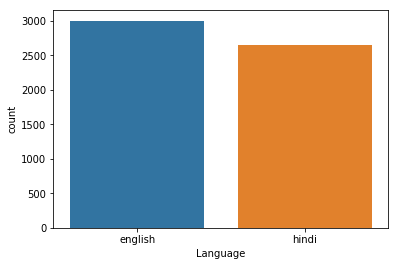

In [8]:
# Countplot of Language
print(articles['Language'].value_counts())
sns.countplot(articles['Language'])

standard    3503
video       1931
gallery      215
Name: Type, dtype: int64


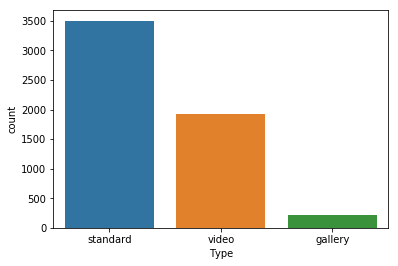

In [9]:
# Countplot of Type
print(articles['Type'].value_counts())
sns.countplot(articles['Type'])

# DATA-PRE-PROCESSING

In [10]:
# Checking duplicate rows
pd.concat(i for _, i in articles.groupby("ArticleId") if len(i) > 1).head()

,ArticleId,Language,Title,Content,Type
7,676938,english,Kodandaram's party gets green signal,"<p>Hyderabad, (Telangana) [India] April. 1 (AN...",standard
10,676938,english,Kodandaram's party gets green signal,NaN,standard
18,676938,english,Kodandaram's party gets green signal,NaN,standard
20,676938,english,Kodandaram's party gets green signal,"<p>Hyderabad, (Telangana) [India] April. 1 (AN...",standard
21,676938,english,Kodandaram's party gets green signal,NaN,standard


In [11]:
df= pd.concat(i for _, i in articles.groupby('ArticleId') if len(i) > 1)

In [12]:
df.head()

,ArticleId,Language,Title,Content,Type
7,676938,english,Kodandaram's party gets green signal,"<p>Hyderabad, (Telangana) [India] April. 1 (AN...",standard
10,676938,english,Kodandaram's party gets green signal,NaN,standard
18,676938,english,Kodandaram's party gets green signal,NaN,standard
20,676938,english,Kodandaram's party gets green signal,"<p>Hyderabad, (Telangana) [India] April. 1 (AN...",standard
21,676938,english,Kodandaram's party gets green signal,NaN,standard


In [13]:
# Getting index of the rows to be deleted 
delete = df[df['Content'].isnull()].index
## dropping indentified rows ##
articles.drop(articles.index[list(delete)], inplace=True)

In [14]:
#  Checking missing values after deleting rows with duplicate 'ArticleId' and 'NaN' in Content field.
null_percent = (articles.isnull().sum()/articles.isnull().count()*100)
null_percent

ArticleId    0.000000
Language     0.000000
Title        0.000000
Content      0.096688
Type         0.000000
dtype: float64

In [15]:
articles.shape

(4137, 5)

In [16]:
# Dropping duplicates based on content and title.
articles.drop_duplicates(subset=['Title','Content'], keep='first', inplace=True)
articles.shape

(2600, 5)

In [17]:
# Dropping duplicates based on content
articles.drop_duplicates(subset='Content', keep='first', inplace = True)
articles.shape

(2327, 5)

In [18]:
pd.concat(i for _, i in articles.groupby('ArticleId') if len(i) > 1).head()

,ArticleId,Language,Title,Content,Type
323,676957,english,J&K: Encounter between security forces & terro...,"New Delhi: On Sunday morning, encounter broke ...",standard
324,676957,english,J&K: Two militants killed in separate encounte...,<strong>Srinagar:</strong> Two militants were ...,standard
344,676957,english,J&K: Encounter between security forces & terro...,"New Delhi: On Sunday morning, two encounters b...",standard
356,676957,english,J&K: Encounter between security forces & terro...,"New Delhi: On Sunday morning, two encounters b...",standard
390,676999,english,"CBSE paper leaks case: 3, including 2 teachers...",New Delhi: In the latest development in CBSE p...,standard


In [19]:
# Checking percentage of null values
percent = (articles.isnull().sum()/articles.isnull().count()*100)
percent

ArticleId    0.000000
Language     0.000000
Title        0.000000
Content      0.042974
Type         0.000000
dtype: float64

In [20]:
# Check null values record
articles[pd.isnull(articles).any(axis=1)]

,ArticleId,Language,Title,Content,Type
2986,682589,english,CBSE row: Una teacher arrested for Economics p...,NaN,standard


In [21]:
articles.drop(articles[pd.isnull(articles).any(axis=1)].index.values, inplace=True)

In [22]:
articles.describe()

,ArticleId,Language,Title,Content,Type
count,2326,2326,2326,2326,2326
unique,1710,2,1807,2326,3
top,681478,hindi,Live Updates: सीरिया पर हुए हमले पर रूस ने कहा...,"<p style=\""text-align: justify;\""><strong>मोती...",standard
freq,19,1535,11,1,1580


In [23]:
articles.isnull().sum()

ArticleId    0
Language     0
Title        0
Content      0
Type         0
dtype: int64

In [24]:
articles.head()

,ArticleId,Language,Title,Content,Type
2,676946,english,"Fadnavis, Piyush Goyal perform 'bhoomi pujan' ...","<p>Latur (Maharashtra) [India], Apr. 1 (ANI): ...",standard
3,676941,english,Bhagalpur violence: Arijit Shashwat surrenders,"<p>Patna (Bihar) [India], Apr. 1 (ANI): Union ...",standard
5,676944,english,Lawyer MPs engaging judge's impeachment barred...,"<p>New Delhi [India], Apr. 1 (ANI): The Bar Co...",standard
7,676938,english,Kodandaram's party gets green signal,"<p>Hyderabad, (Telangana) [India] April. 1 (AN...",standard
9,676942,english,"Trump targets Amazon again, accuses it of scam...","<p>Washington DC, [United States] April 1 (ANI...",standard


In [25]:
# function to remove puntuations from string
def removePunc(stringWithPunc):
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) 
    return stringWithPunc.translate(translator)

# function to remove newLine characters
def removeWebLinks(stringWithLinks):
    return re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', stringWithLinks)

#  function to remove new line characters from a string
def removeNewLineChars(stringWithNewlineChars):
    stringWithNewlineChars = stringWithNewlineChars.replace('\r', '')
    stringWithNewlineChars = stringWithNewlineChars.replace('\n', '')
    return stringWithNewlineChars

#  function to remove leading and trailing spaces
def removeLTspace(stringWithLTspace):
    return stringWithLTspace.strip()

# function to remove PHP tags from string 
def removePHPtags(stringWithPHP):
    return BeautifulSoup(stringWithPHP, "lxml").text

#  function to replace - with space 
def removeDashWSpace(stringWithDash):
    return stringWithDash.replace('-',' ')

## function to remove extra spaces from string 
def removeExtraSpace(stringWithSpace):
    return re.sub(' +',' ',stringWithSpace)

In [26]:
indexValues = articles.index.values
for i in indexValues:
    articles.loc[i,'Content'] = removePHPtags(articles.loc[i,'Content'])    

    articles.loc[i,'Content'] = removeWebLinks(articles.loc[i,'Content']) 
    
    articles.loc[i,'Content'] = removeDashWSpace(articles.loc[i,'Content']) 
    
    articles.loc[i,'Content'] = removePunc(articles.loc[i,'Content'])
    
    articles.loc[i,'Content'] = removeExtraSpace(articles.loc[i,'Content'])  
    
    articles.loc[i,'Content'] = removeNewLineChars(articles.loc[i,'Content'])  
    
    articles.loc[i,'Content'] = removeLTspace(articles.loc[i,'Content'])

In [27]:
articlesEnglish = articles.loc[articles['Language'] == 'english', :]
articlesHindi = articles.loc[articles['Language'] == 'hindi', :]

In [28]:
articlesEnglish.head()

,ArticleId,Language,Title,Content,Type
2,676946,english,"Fadnavis, Piyush Goyal perform 'bhoomi pujan' ...",Latur Maharashtra India Apr 1 ANI Maharashtra ...,standard
3,676941,english,Bhagalpur violence: Arijit Shashwat surrenders,Patna Bihar India Apr 1 ANI Union Minister Ash...,standard
5,676944,english,Lawyer MPs engaging judge's impeachment barred...,New Delhi India Apr 1 ANI The Bar Council of I...,standard
7,676938,english,Kodandaram's party gets green signal,Hyderabad Telangana India April 1 ANI The Elec...,standard
9,676942,english,"Trump targets Amazon again, accuses it of scam...",Washington DC United States April 1 ANI United...,standard


In [29]:
articlesHindi.head()

,ArticleId,Language,Title,Content,Type
3001,821947,hindi,जम्मू-कश्मीर: अनंतनाग में एक आतंकी ढेर और एक ग...,श्रीनगर जम्मू कश्मीर में देर रात सुरक्षाबलों औ...,standard
3002,821936,hindi,भागलपुर हिंसा: अश्विनी चौबे के बेटे अर्जित का ...,पटना बिहार के भागलपुर में भड़की हिंसा के आरोप...,standard
3003,821936,hindi,भागलपुर दंगा: केंद्रीय मंत्री अश्विनी चौबे के ...,पटना भागलपुर दंगा मामले में एक सप्ताह से फरार...,standard
3004,821936,hindi,भागलपुर दंगा: केंद्रीय मंत्री अश्विनी चौबे के ...,पटना भागलपुर दंगा मामले में एक सप्ताह से फरार...,standard
3005,821936,hindi,भागलपुर दंगा: केंद्रीय मंत्री अश्विनी चौबे के ...,पटना भागलपुर दंगा मामले में एक सप्ताह से फरार...,standard


In [30]:
indexArticlesEnglish = articlesEnglish.index.values
for i in indexArticlesEnglish:
    stop = set(stopwords.words('english'))
    
    articlesEnglish.loc[i,'Content'] = [i for i in articlesEnglish.loc[i,'Content'].lower().split() if i not in stop]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [31]:
ps = PorterStemmer()

indexArticlesEnglish = articlesEnglish.index.values
for i in indexArticlesEnglish:
    
    for j in range(len(articlesEnglish.loc[i,'Content'])):
        articlesEnglish.loc[i,'Content'][j] = ps.stem(articlesEnglish.loc[i,'Content'][j])

In [32]:
articlesEnglish['Content']=[" ".join(Engcontent) for Engcontent in articlesEnglish['Content'].values]
articlesHindi['Content']=[" ".join(Hincontent) for Hincontent in articlesHindi['Content'].values]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [33]:
# Joining Hindi and English file

articleBoth = articlesEnglish.append(articlesHindi, ignore_index=True)

In [34]:
articleBoth.head()

,ArticleId,Language,Title,Content,Type
0,676946,english,"Fadnavis, Piyush Goyal perform 'bhoomi pujan' ...",latur maharashtra india apr 1 ani maharashtra ...,standard
1,676941,english,Bhagalpur violence: Arijit Shashwat surrenders,patna bihar india apr 1 ani union minist ashwi...,standard
2,676944,english,Lawyer MPs engaging judge's impeachment barred...,new delhi india apr 1 ani bar council india bc...,standard
3,676938,english,Kodandaram's party gets green signal,hyderabad telangana india april 1 ani elect co...,standard
4,676942,english,"Trump targets Amazon again, accuses it of scam...",washington dc unit state april 1 ani unit stat...,standard


In [35]:
# making TfidfVector object
tfidf = TfidfVectorizer()

# tfidfMatrix
TfidfMatrix = tfidf.fit_transform(articleBoth['Content'])

# Cosine similarity
cosine_similarities = linear_kernel(TfidfMatrix, TfidfMatrix)
print(cosine_similarities)
print(cosine_similarities.shape)

[[1.         0.04277784 0.04042608 ... 0.         0.         0.        ]
 [0.04277784 1.         0.11514344 ... 0.         0.         0.        ]
 [0.04042608 0.11514344 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(2326, 2326)


In [36]:
similarityMatrix = cosine_similarities.argsort()[:,2319:2325]
similarityMatrix = np.fliplr(similarityMatrix)
print(similarityMatrix)
print(similarityMatrix.shape)

[[597 706  33 363 233 368]
 [ 17  63 436  36  40  42]
 [258 259 193 653 650 642]
 ...
 [798 778 777 776 775 774]
 [798 778 777 776 775 774]
 [798 778 777 776 775 774]]
(2326, 6)


In [37]:
# Making Dataframe

file= articleBoth.loc[:,['Title']]
file['1_Similar'] = np.nan
file['2_Similar'] = np.nan
file['3_Similar'] = np.nan
file['4_Similar'] = np.nan
file['5_Similar'] = np.nan
file['6_Similar'] = np.nan

# inserting similar titles into the dataframe
for i in range(similarityMatrix.shape[0]):
    for j in range(similarityMatrix.shape[1]):
        file.iloc[i,j+1] = articleBoth.loc[similarityMatrix[i,j] ,'Title']

In [38]:
file

,Title,1_Similar,2_Similar,3_Similar,4_Similar,5_Similar,6_Similar
0,"Fadnavis, Piyush Goyal perform 'bhoomi pujan' ...",Fadnavis reviews progress of Jalyukt Shivar Ab...,Master Stroke: Shiv Sena protests against Maha...,How to deal with body odour this summer?,PM Modi lauds Bihar Govt. on successful Swachh...,Aaj Ka Arjun: Aaj Ka Arjun: PM Narendra Modi's...,Reduce inequalities to resolve India's environ...
1,Bhagalpur violence: Arijit Shashwat surrenders,"Arijit Shashwat was arrested, claims police",Aaj Ka Arjun: Rift between Nitish and BJP's fr...,Bhagalpur violence: Arijit Shashwat released f...,Bhagalpur Violence: Union Minister Ashwini Cho...,Bhagalpur Violence: Union Minister Ashwini Cho...,Bhagalpur communal clash case: Arijit Shashwat...
2,Lawyer MPs engaging judge's impeachment barred...,Delhi court lawyers to hold strike against att...,Protesting lawyers shave their heads in Bhopal,PM Narendra Modi to observe day-long fast on A...,Unnao gangrape case: UP police bowed down to p...,Unnao gangrape case: UP police bowed down to p...,Unnao gangrape case: UP police bowed down to p...
3,Kodandaram's party gets green signal,"Ramdev meets Nizamabad MP, hints support to th...",Panchayat Polls: West Bengal EC revokes extend...,Panchayat Polls: Calcutta HC directs state EC ...,"KCR to meet Deve Gowda, likely to discuss form...",Congress' 1st list for Karnataka assembly poll...,Congress' 1st list for Karnataka assembly poll...
4,"Trump targets Amazon again, accuses it of scam...",Trump freezes $200 mn in Syrian recovery funds...,Trump calls off his South America visit,"Will meet Kim in May or early June, says Trump",China gained from 'poor' US leadership in past...,Trump lauds US administration for handling IS ...,"Chelsea Handler supports Stormy Daniels, says ..."
5,Trump freezes $200 mn in Syrian recovery funds...,Trump lauds US administration for handling IS ...,Trump calls off his South America visit,Major decisions on Syria within 48 hours: Trump,"US, Russia clash at UNSC over probing chemical...",Trump to decide in next 24-48 hours on action ...,"Will meet Kim in May or early June, says Trump"
6,Imam who lost son in Asansol riot appeals for ...,Panchayat Polls: Calcutta HC directs state EC ...,WB Panchayat Election: EC extends last date fo...,Rahul Gandhi goes for low-level politics; his ...,Panchayat Polls: West Bengal EC revokes extend...,Kaun Jitega 2019: BJP delegation visits relief...,WBJEE Admit Card 2018: Here is how to download
7,Students in Chhattisgarh village still await p...,UP: Residents of Van Tangia bemoan lack of ame...,"Mahindra Electric, Zoomcar partner to offer se...",Honda Working On Electric Scooter For India,Gorakhpur: 6 die as car turns turtle,Relais &amp; Châteaux announce April 10 as fir...,Fadnavis reviews progress of Jalyukt Shivar Ab...
8,Gaza protest: Netanyahu heaps praises on Israe...,Bangladesh: 100 injured in clashes during mass...,Politics of Bharat Bandh and its consequences,Politics of Bharat Bandh and its consequences,Bharat Bandh 2.0 LIVE UPDATES: Maximum protest...,Bharat Bandh 2.0 LIVE UPDATES: Protests taking...,Bharat Bandh 2.0 LIVE UPDATES: Protests taking...
9,Chennai's Integral Coach Factory records new-h...,"CBSE paper leak: 2 teachers, 1 coaching centre...",Honda Reveals Plans For FY 2018-19,The medal doesn't only belongs to me: Sushil o...,VIDEO: Man gets electrocuted on top of train d...,Harbhajan Singh `heartbroken` over shifting of...,Manipur on entrepreneurship map with 'Made in ...


In [39]:
file.to_csv('SimilarResults.csv')